# ДЗ №1: Визуализация механизмов Attention в трансформерах

## 🎯 Цель задания
После выполнения задания вы сможете:
- Визуализировать работу self-attention механизма
- Сравнивать различные реализации QKV в BERT, GPT и T5
- Анализировать позиционные векторы и их влияние на понимание последовательности
- Интерпретировать attention-карты для объяснения решений модели

## 📝 Структура задания
- **Часть 1** (обязательная, 70% оценки): Базовая визуализация attention
- **Часть 2** (дополнительная, 30% оценки): Продвинутый анализ

## ⚡ Критерии оценки
- Корректность кода: 40%
- Качество визуализации: 30%
- Анализ результатов: 30%


## 🔧 Установка зависимостей

Установим необходимые библиотеки для работы с трансформерами и визуализации.


In [ ]:
%pip install -q transformers torch matplotlib seaborn bertviz numpy pandas
%pip install -q ipywidgets

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    AutoTokenizer, AutoModel,
    BertTokenizer, BertModel,
    GPT2Tokenizer, GPT2Model,
    T5Tokenizer, T5Model
)
from bertviz import model_view, head_view
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline
1

1

## 📊 Часть 1: Основные задания (обязательная часть)

### Задание 1.1: Загрузка и подготовка моделей


In [ ]:
models_info = {
    'BERT': {
        'model_name': 'bert-base-uncased',
        'tokenizer': None,
        'model': None
    },
    'GPT-2': {
        'model_name': 'gpt2',
        'tokenizer': None,
        'model': None
    }
}

models_info['BERT']['tokenizer'] = BertTokenizer.from_pretrained(models_info['BERT']['model_name'])
models_info['BERT']['model'] = BertModel.from_pretrained(models_info['BERT']['model_name'], output_attentions=True)

models_info['GPT-2']['tokenizer'] = GPT2Tokenizer.from_pretrained(models_info['GPT-2']['model_name'])
models_info['GPT-2']['model'] = GPT2Model.from_pretrained(models_info['GPT-2']['model_name'], output_attentions=True)
models_info['GPT-2']['tokenizer'].pad_token = models_info['GPT-2']['tokenizer'].eos_token #добавим eos_token как pad_token.

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

### Задание 1.2: Токенизация и получение attention весов

In [ ]:
# Тестовый текст для анализа
test_text = "The grass was green in such cool weather."
# test_text = "The quick brown fox jumps over the lazy dog"


def get_attention_weights(text, model_name):
    """
    Получение attention весов для заданного текста и модели
    """
    tokenizer = models_info[model_name]['tokenizer']
    model = models_info[model_name]['model']

    inputs = tokenizer(text, return_tensors='pt')

    outputs = model(**inputs)
    attention_weights = outputs.attentions

    # Вектор, который получается для [CLS] после всех слоёв — это и есть то, что возвращается как pooler_output.
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])[1:-1]

    return attention_weights, tokens, inputs

bert_attention, bert_tokens, bert_inputs = get_attention_weights(test_text, 'BERT')
gpt2_attention, gpt2_tokens, gpt2_inputs = get_attention_weights(test_text, 'GPT-2')

print(f"BERT tokens: {bert_tokens}")
print(f"GPT-2 tokens: {gpt2_tokens}")
print(f"BERT attention shape: {bert_attention[0].shape}")
print(f"GPT-2 attention shape: {gpt2_attention[0].shape}")


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


BERT tokens: ['the', 'grass', 'was', 'green', 'in', 'such', 'cool', 'weather', '.']
GPT-2 tokens: ['Ġgrass', 'Ġwas', 'Ġgreen', 'Ġin', 'Ġsuch', 'Ġcool', 'Ġweather']
BERT attention shape: torch.Size([1, 12, 11, 11])
GPT-2 attention shape: torch.Size([1, 12, 9, 9])


### Задание 1.3: Создание базовой attention heatmap

In [ ]:
def merge_subtokens(tokens, model_name):
    words = []
    current_word = ''

    if model_name == 'BERT':
        for token in tokens:
            if token.startswith('##'):
                current_word += token[2:]
            else:
                if current_word:
                    words.append(current_word)
                current_word = token
        if current_word:
            words.append(current_word)

    elif model_name == 'GPT-2':
        for token in tokens:
            if token.startswith('Ġ'):
                if current_word:
                    words.append(current_word)
                current_word = token[1:]  # убираем специальный символ
            else:
                current_word += token
        if current_word:
            words.append(current_word)

    else:
        words = tokens

    return words


def plot_attention_heatmap(attention_weights, tokens, model_name, layer_idx=5, head_idx=7):
    attention_matrix = attention_weights[layer_idx][0][head_idx].detach().numpy()

    # уберем спецтокены для BERT это [CLS], [SEP], для GPT-2  нет
    if model_name == 'BERT':
        attention_matrix = attention_matrix[1:-1, 1:-1]
        tokens = tokens[1:-1]
        words = merge_subtokens(tokens, model_name)
    elif model_name == 'GPT-2':
        words = merge_subtokens(tokens, model_name)
    else:
        words = tokens

    #  индексы субтокенов по словам
    groups = []
    current_group = []
    for i, token in enumerate(tokens):
        if model_name == 'BERT' and token.startswith('##'):
            current_group.append(i)
        elif model_name == 'GPT-2' and not token.startswith('Ġ') and current_group:
            current_group.append(i)
        else:
            if current_group:
                groups.append(current_group)
            current_group = [i]
    if current_group:
        groups.append(current_group)

    word_attention = np.zeros((len(groups), len(groups)))
    for i, group_i in enumerate(groups):
        for j, group_j in enumerate(groups):
            submatrix = attention_matrix[np.ix_(group_i, group_j)]
            word_attention[i, j] = submatrix.mean()

    plt.figure(figsize=(max(6, len(words)), max(6, len(words))))
    ax = sns.heatmap(
        word_attention,
        xticklabels=words,
        yticklabels=words,
        cmap='viridis',
        square=True,
        cbar=True,
        linewidths=0.5,
        linecolor='gray'
    )
    ax.invert_yaxis()

    plt.title(f'{model_name} - Layer {layer_idx}, Head {head_idx}\nAttention Weights')
    plt.xlabel('Key (Attended to)')
    plt.ylabel('Query (Attending from)')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

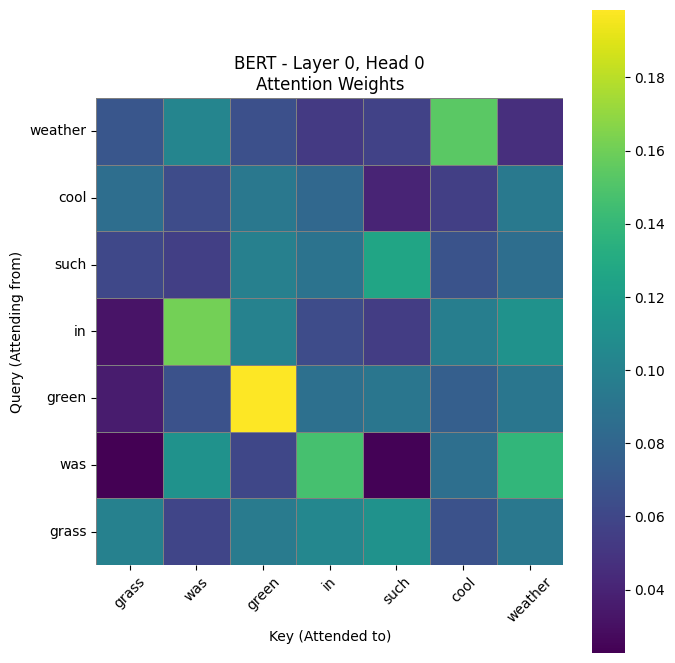

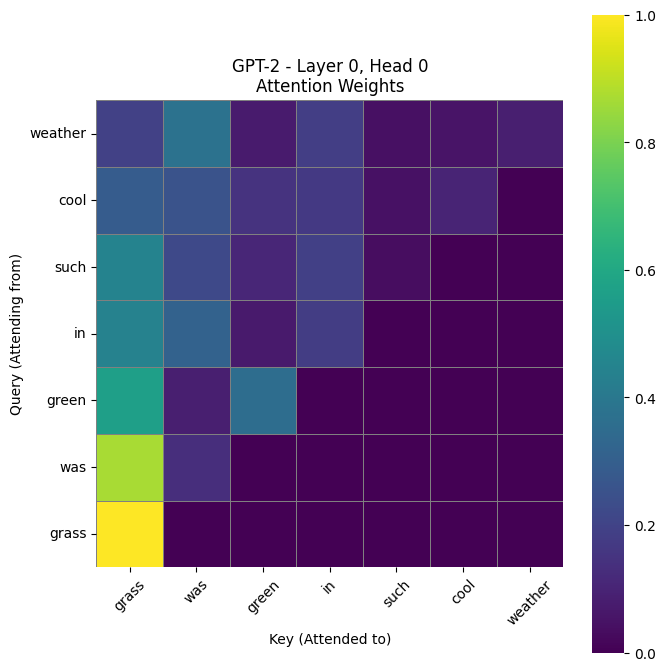

In [ ]:
plot_attention_heatmap(bert_attention, bert_tokens, 'BERT', layer_idx=0, head_idx=0)
plot_attention_heatmap(gpt2_attention, gpt2_tokens, 'GPT-2', layer_idx=0, head_idx=0)

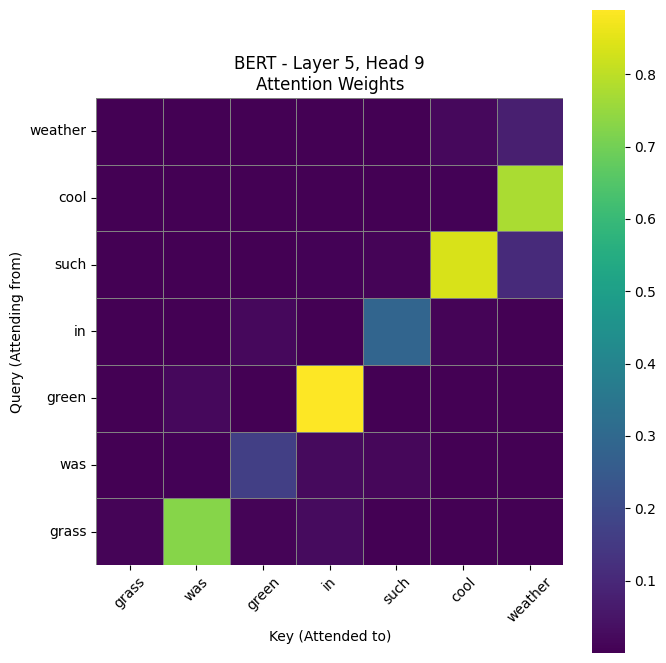

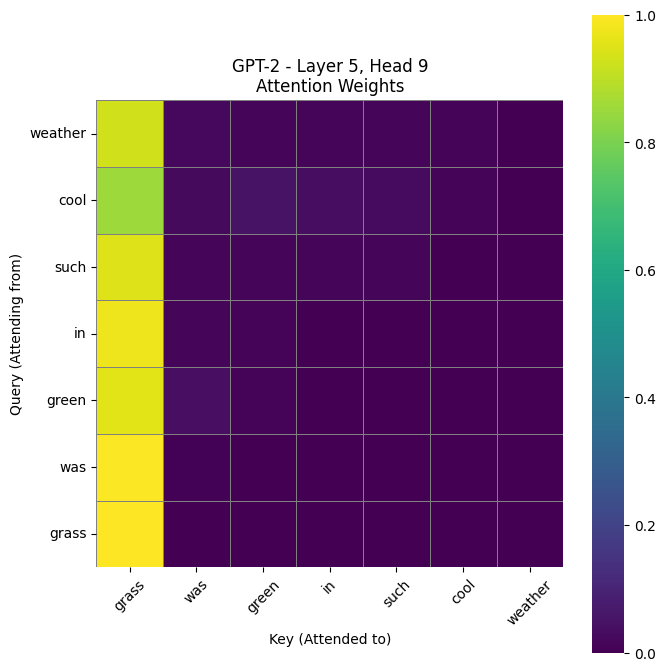

In [ ]:
plot_attention_heatmap(bert_attention, bert_tokens, 'BERT', layer_idx=5, head_idx=9)
plot_attention_heatmap(gpt2_attention, gpt2_tokens, 'GPT-2', layer_idx=5, head_idx=9)

### Задание 1.4: Анализ результатов

**TODO: Ответьте на следующие вопросы:**


1. **Какие различия вы заметили в attention patterns между BERT и GPT-2?**

**GPT-2**:

- однаправленное (unidirectional) внимание, слева направо — внимание смотрит только на предыдущие токены (то есть на контекст слева).
- используется только декодер
- маска внимания (causal mask), которая блокирует доступ к будущим токенам
- у модели есть только один входной токен, так что первая траектория окажется единственной активной.
- токены с префиксом 'Ġ' указывают на начало слова.


**BERT**:
- двунаправленное (маскированное) внимание — учитываются и левый, и правый контекст.
- используется только энкодер
- на эмбединги слова влияют как предшествующие, так и последующие слова в предложении.
- входной текст обрамляется специальными токенами [CLS] (начало) и [SEP] (конец).


2. **Как изменяются attention веса в разных слоях?**

**BERT:**  
- Нижние слои — модель улавливает локальные зависимости.  
- Верхние слои — начинает захватывать более сложные паттерны, включая семантику и связи по всему предложению (двунаправленное внимание).

**GPT:**  
- Нижние слои — модель улавливает локальные зависимости на предыдущих токенах.  
- Верхние слои — начинает строить более сложные паттерны и семантику, учитывая последовательный контекст слева, без доступа к будущим токенам.


3. **Какую роль играют позиционные кодировки?**

Позиционное кодирование - способ добавить в модель информацию о позиции каждого токена в последовательности. В оригинальной статье оно прибавляется к эмбеддингам токенов до входа в первый слой self-attention. Без positional encoding модель теряет важную структурную информацию (порядок слов). Правильное позиционное кодирование помогает модели лучше понимать локальный контекст и длинные зависимости


## 🚀 Часть 2: Дополнительные задания (30% оценки)

### Задание 2.1: Исследование Multi-Head Attention


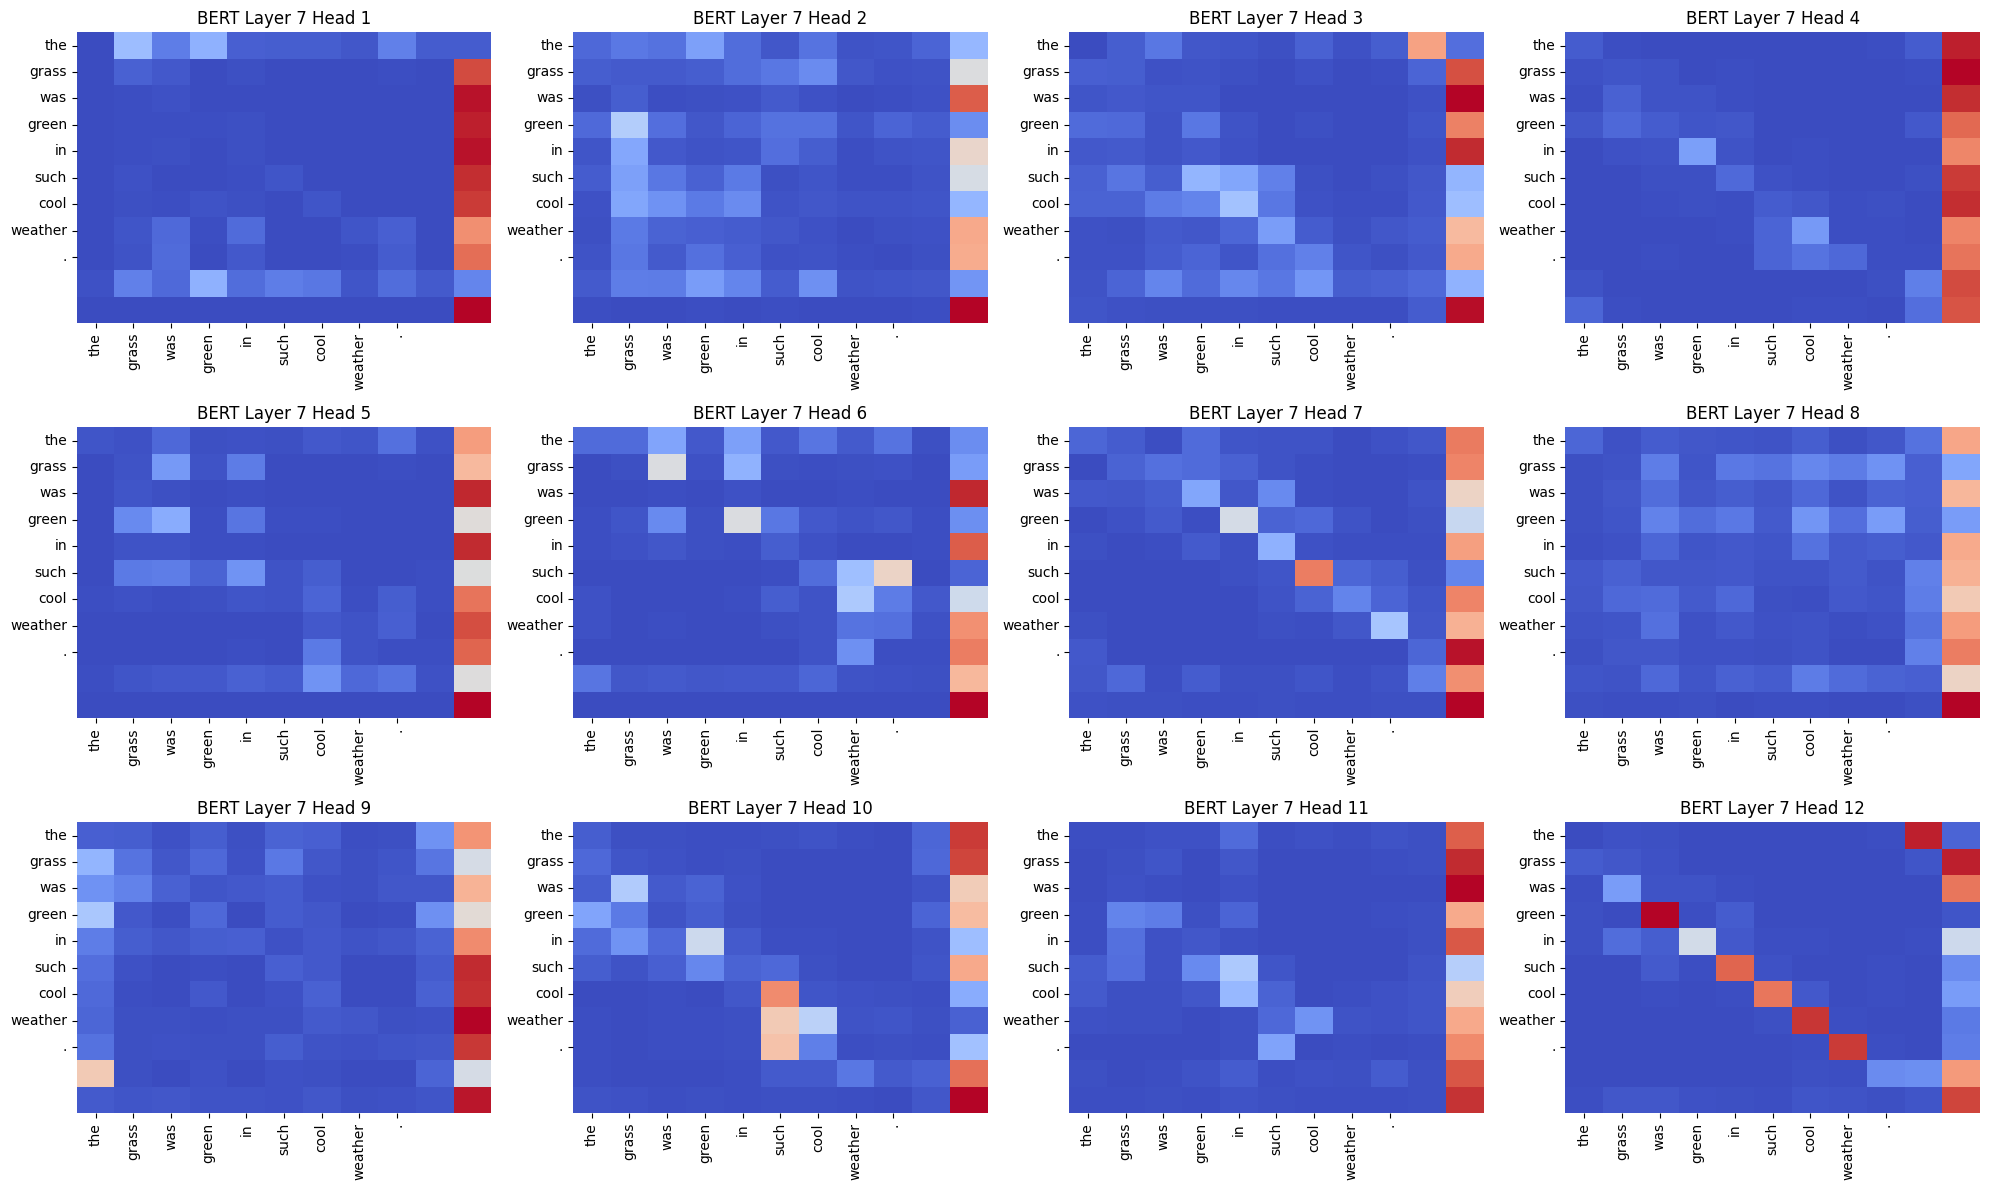

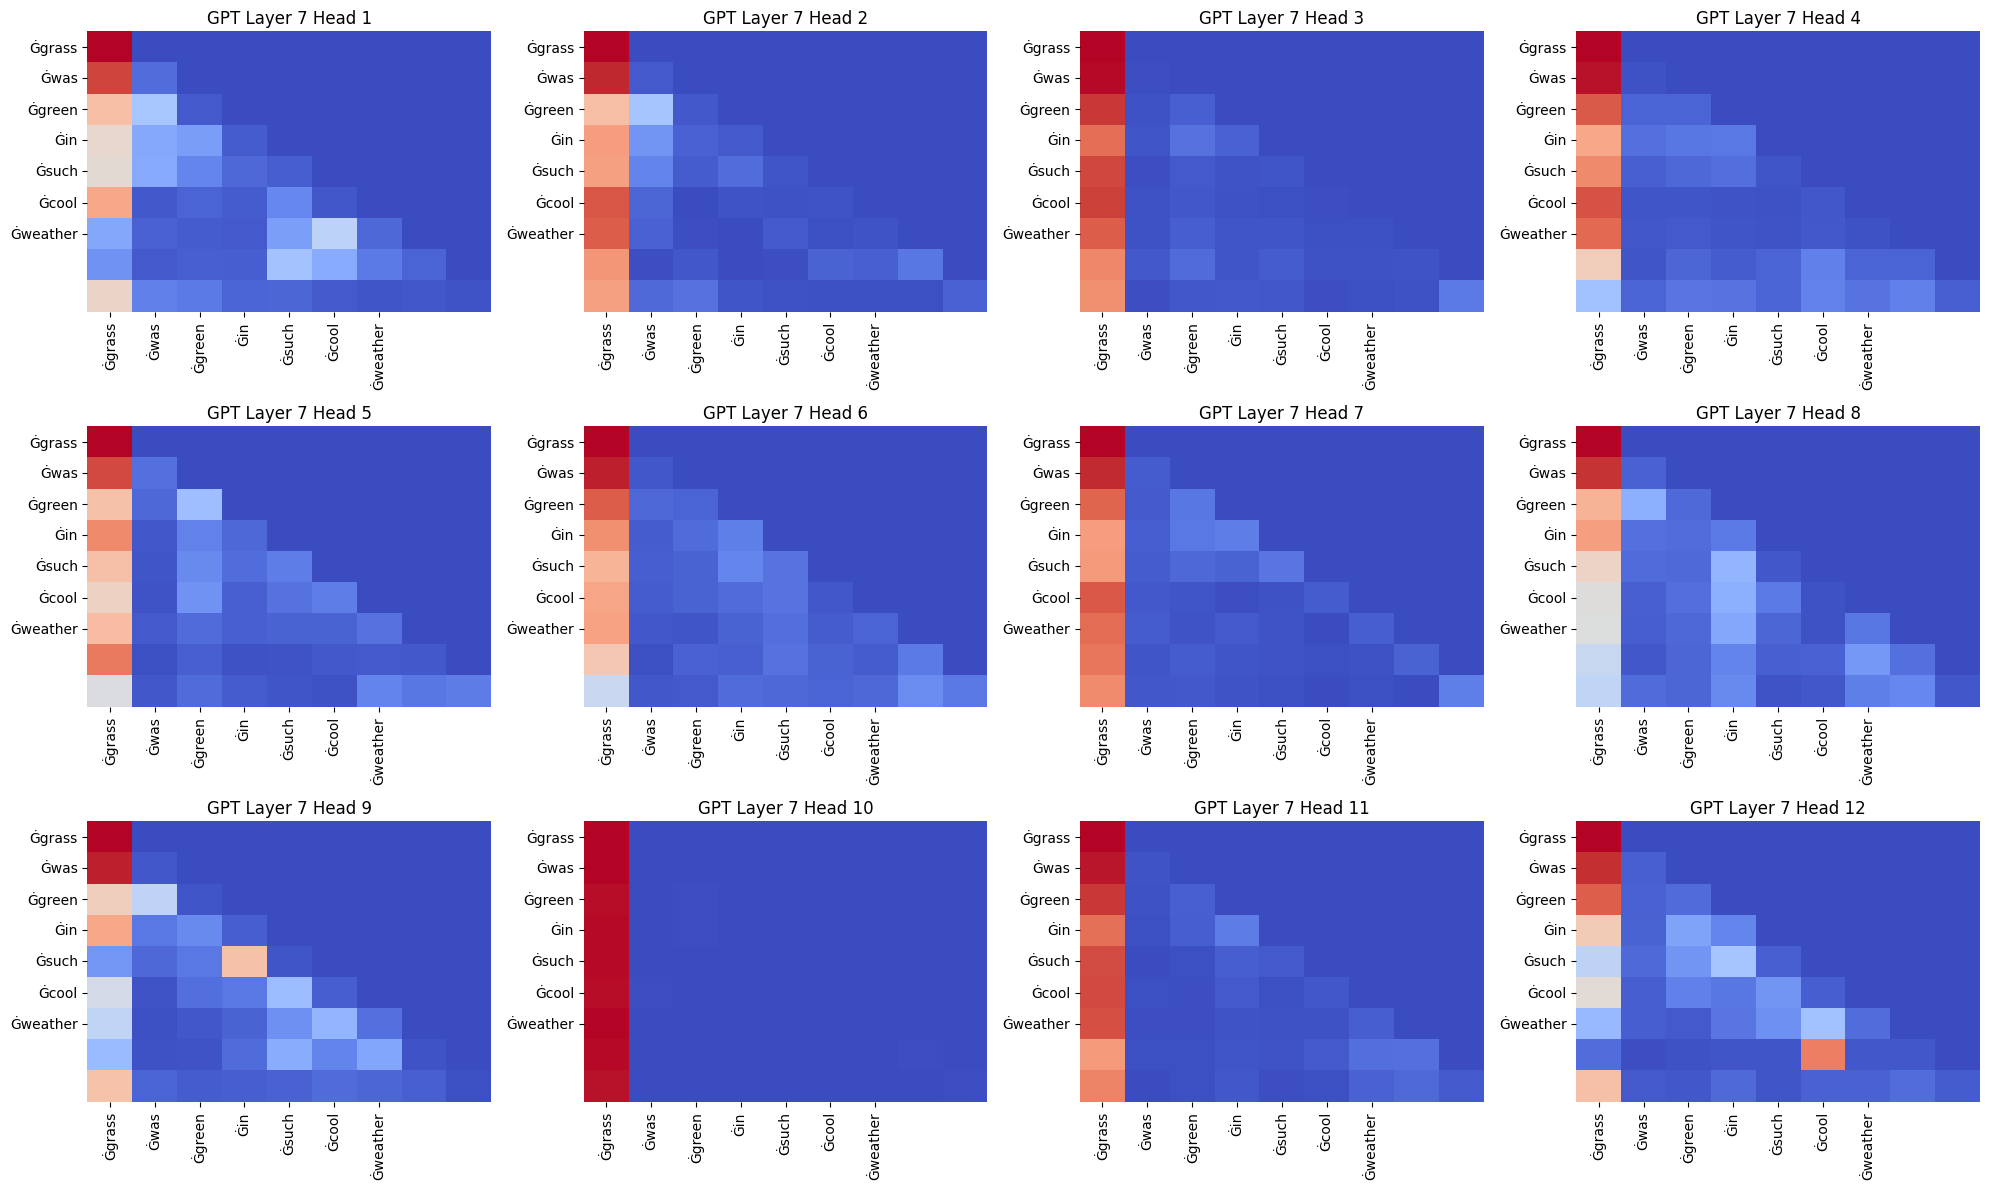

In [ ]:
def analyze_multi_head_attention(attention_weights, tokens, model_name, layer_idx=6):
    attentions = attention_weights[layer_idx]
    num_heads = attentions.shape[1]

    cols = 4
    rows = num_heads // cols + int(num_heads % cols != 0)

    fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axs = axs.flatten()

    for i in range(num_heads):
        sns.heatmap(
            attentions[0, i].detach().cpu().numpy(),
            xticklabels=tokens,
            yticklabels=tokens,
            ax=axs[i],
            cmap='coolwarm',
            cbar=False
        )
        axs[i].set_title(f'{model_name} Layer {layer_idx+1} Head {i+1}')
        axs[i].tick_params(axis='x', rotation=90)
        axs[i].tick_params(axis='y', rotation=0)

    for j in range(num_heads, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()


analyze_multi_head_attention(bert_attention, bert_tokens, 'BERT', layer_idx=6)

analyze_multi_head_attention(gpt2_attention, gpt2_tokens, 'GPT', layer_idx=6)


### Задание 2.2: Создание attention-карт для русскоязычного текста


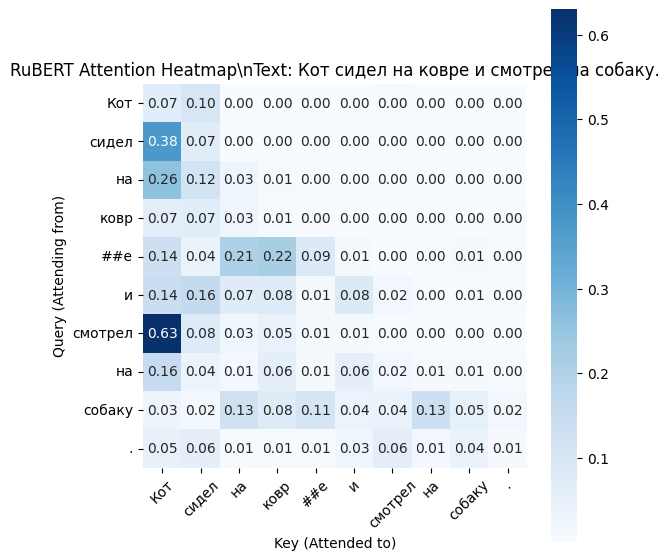


Токены: ['Кот', 'сидел', 'на', 'ковр', '##е', 'и', 'смотрел', 'на', 'собаку', '.']
Количество слоев: 3
Количество голов: 12


In [ ]:
# TODO: Загрузите русскоязычную модель и проанализируйте attention для русского текста
# ========= РЕШЕНИЕ: =========
from transformers import AutoTokenizer, AutoModel

ru_tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
ru_model = AutoModel.from_pretrained("cointegrated/rubert-tiny2", output_attentions=True)

# Русский текст для анализа
russian_text = "Кот сидел на ковре и смотрел на собаку."

def analyze_russian_attention(text, tokenizer, model):
    """
    Анализ attention для русского текста
    """
    inputs = tokenizer(text, return_tensors='pt')
    outputs = model(**inputs)

    layer_idx = len(outputs.attentions) - 1
    head_idx = 0

    attention_weights = outputs.attentions[layer_idx][0][head_idx].detach().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])[1:-1]

    # Создаем heatmap для последнего слоя
    attention_matrix = attention_weights[1:-1, 1:-1]

    plt.figure(figsize=(6, 6))
    sns.heatmap(
        attention_matrix,
        xticklabels=tokens,
        yticklabels=tokens,
        cmap='Blues',
        cbar=True,
        square=True,
        annot=True,
        fmt='.2f'
    )

    plt.title(f'RuBERT Attention Heatmap\\nText: {text}')
    plt.xlabel('Key (Attended to)')
    plt.ylabel('Query (Attending from)')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return outputs.attentions, tokens

# Анализируем русский текст
ru_attention, ru_tokens = analyze_russian_attention(russian_text, ru_tokenizer, ru_model)

print(f"\nТокены: {ru_tokens}")
print(f"Количество слоев: {len(ru_attention)}")
print(f"Количество голов: {ru_attention[0].shape[1]}")


## 📈 Итоговый анализ и выводы

### Задание 3: Сравнительный анализ

**TODO: Сделайте итоговые выводы по результатам всех экспериментов:**


1. **Основные различия между BERT и GPT-2:**

GPT:
- генеративная языковая модель  
- однонаправленная архитектура (слева направо)  
- обучается по авторегрессивной схеме: предсказывает следующее слово, имея доступ только к предыдущим  
- использует self-attention с каузальной маской: внимание только на предыдущие токены  
- применяется в задачах генерации текста

BERT:
- использует только **энкодер** из архитектуры трансформера  
- двунаправленная (учитывает и левый, и правый контекст)  
- обучается по схеме автоэнкодера: случайные слова в предложении маскируются, и модель учится их восстанавливать по окружающему контексту  
- применяется в задачах понимания текста


2. **Как attention головы специализируются:**

каждая голова учится обращать внимание на разные аспекты входа. в BERT, например, нижние головы чаще ловят локальные зависимости, верхние — глобальные семантические паттерны

3. **Особенности русскоязычных моделей:**

-  дообучаются на русскоязычных данных
- токенизация сложнее из-за кириллицы и богатой морфологии
- cвободный порядок слов в русском против жёсткого в английском.
- d русском из-за богатой морфологии и длины слов токенизация должна учитывать многочисленные окончания и приставки, что ведёт к более раздробленному представлению слов, повышая размер словаря
- многие русскоязычные модели создаются путём дообучения англоязычных моделей (например, GPT-2) на русских текстах, а не с нуля

4. **Практические применения полученных знаний:**

- демонстрация заказчику причин предсказаний через визуализацию внимания и градиентов (частичное объяснение black-box), что повышает доверие и понимание модели
- диагностика ошибок модели по паттернам внимания и значимости токенов для улучшения качества предсказаний
- оптимизация архитектуры — выявление и отключение неэффективных голов и слоёв внимания для повышения производительности и снижения вычислительных затрат


## 🎯 Заключение

В этом задании вы:
- ✅ Изучили механизмы attention в трансформерах
- ✅ Сравнили разные архитектуры (BERT vs GPT-2)
- ✅ Проанализировали специализацию attention голов
- ✅ Работали с русскоязычными моделями

Полученные навыки визуализации и анализа attention будут полезны для:
- Отладки и оптимизации моделей
- Объяснения решений AI-систем
- Выбора подходящей архитектуры для задач
- Интерпретации поведения моделей

## 📋 Критерии сдачи ДЗ

### Обязательная часть (70% оценки):
- [x] Загружены и настроены модели BERT и GPT-2
- [x] Реализована функция получения attention весов
- [x] Создана базовая визуализация attention heatmap
- [x] Даны ответы на аналитические вопросы

### Дополнительная часть (30% оценки):
- [x] Проанализированы multi-head attention паттерны
- [x] Работа с русскоязычной моделью
- [x] Итоговый сравнительный анализ

**Удачи в дальнейшем изучении трансформеров! 🚀**


In [ ]:
pip install --upgrade nbformat nbconvert ipywidgets
